<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Dog Behaviour Analyser

## Part 2

[Click here to Part 1 for details of project](01%20Project%20Details.ipynb)

## Contents:
- [Data Import & Preprocessing](#Data-Import-&-Preprocessing)
- [EDA](#EDA)
- [Modelling](#Modelling)
- [Recommendations](#Recommendations)

In [32]:
import cv2
import os
import PIL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski
from PIL import Image

import pickle

# Modelling
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import efficientnet.keras as efn

### Data Import & Preprocessing

In [34]:
# Separate out the data to train and validation directories
# In each directories, classify each class in the subdirectory

train_dir = '../data/train_data/'
validation_dir = '../data/validation_data/'

# Train Data
train_angry = '../data/train_data/angry/'
train_happy = '../data/train_data/happy/'
train_relaxed = '../data/train_data/relaxed/'
train_sad = '../data/train_data/sad/'

# Validation Data
validation_angry = '../data/validation_data/angry/'
validation_happy = '../data/validation_data/happy/'
validation_relaxed = '../data/validation_data/relaxed/'
validation_sad = '../data/validation_data/sad/'

# Train Data path
train_angry_dir = os.listdir(train_angry)
train_happy_dir = os.listdir(train_happy)
train_relaxed_dir = os.listdir(train_relaxed)
train_sad_dir = os.listdir(train_sad)

# Validation Data path
validation_angry_dir = os.listdir(validation_angry)
validation_happy_dir = os.listdir(validation_happy)
validation_relaxed_dir = os.listdir(validation_relaxed)
validation_sad_dir = os.listdir(validation_sad)

In [38]:
def count_files_in_folder(folder_path):
    files_list = os.listdir(folder_path)
    num_files = len(files_list)
    return num_files

In [6]:
'''
# Calculate the number of files for each class in train data folder
folder_paths = [train_angry,train_happy,train_relaxed,train_sad]

for folder_path in folder_paths:
    num_files = count_files_in_folder(folder_path)
    print(f"Number of files in '{folder_path}': {num_files}")
'''

Number of files in '../data/train_data/angry/': 101
Number of files in '../data/train_data/happy/': 100
Number of files in '../data/train_data/relaxed/': 100
Number of files in '../data/train_data/sad/': 100


In [39]:
# Calculate the number of files for each class in validation data folder
folder_paths = [validation_angry,validation_happy,validation_relaxed,validation_sad]

for folder_path in folder_paths:
    num_files = count_files_in_folder(folder_path)
    print(f"Number of files in '{folder_path}': {num_files}")

Number of files in '../data/validation_data/angry/': 211
Number of files in '../data/validation_data/happy/': 340
Number of files in '../data/validation_data/relaxed/': 202
Number of files in '../data/validation_data/sad/': 252


### Image Augmentation

In [10]:
# Only run this cell when you want to augment more images
'''
def augment_image(class_name):    
    # Define the data folder and output folder
    data_folder = "../data/train_data/"+class_name+"/"
    output_folder = "../data/train_data/"+class_name+"/"

    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Make sure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through the images in the data folder and generate augmented images
    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(root, file)
                img = tf.keras.preprocessing.image.load_img(image_path)
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = tf.keras.preprocessing.image.array_to_img(batch[0])
                    augmented_image.save(os.path.join(output_folder, f"{file.split('.')[0]}_{i}.{file.split('.')[-1]}"))
                    i += 1
                    if i >= 20:  # Generate a maximum of 20 augmented images per original image
                        break

    print("Augmentation complete.")

augment_image('angry')
augment_image('happy')
augment_image('relaxed')
augment_image('sad')

'''

Augmentation complete.
Augmentation complete.
Augmentation complete.
Augmentation complete.


In [40]:
# Calculate the number of files for each class in train data folder after image augmentation
folder_paths = [train_angry,train_happy,train_relaxed,train_sad]

for folder_path in folder_paths:
    num_files = count_files_in_folder(folder_path)
    print(f"Number of files in '{folder_path}': {num_files}")

Number of files in '../data/train_data/angry/': 2101
Number of files in '../data/train_data/happy/': 2101
Number of files in '../data/train_data/relaxed/': 2100
Number of files in '../data/train_data/sad/': 2100


|Feature|Type|Description|
|---|---|---|
|**train_data**|*jpg*|4 classes of dog emotions:<br>Angry - 2101 images<br>Happy - 2101 images<br>Relaxed - 2100 images<br>Sad - 2100 images|
|**validation_data**|*jpg*|4 classes of dog emotions:<br>Angry - 211 images<br>Happy - 340 images<br>Relaxed - 202 images<br>Sad - 252 images|


## EDA

Please refer to the pdf slides for more in-depth analysis of the different emotions of a dog.

In [35]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(384, 384))
    return image[...,::-1]

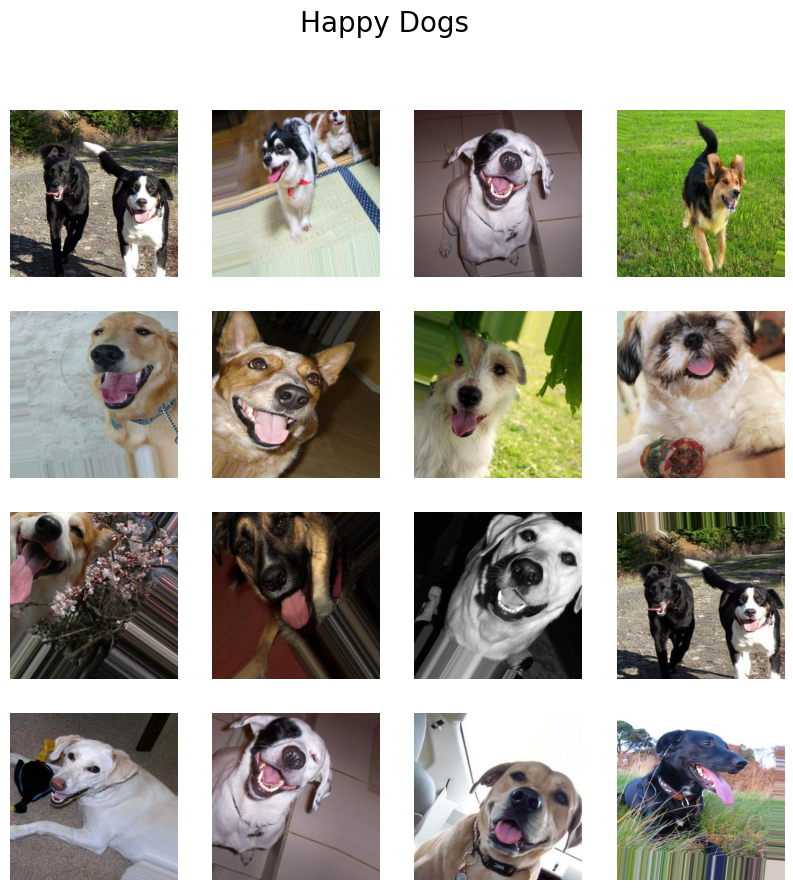

In [45]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_happy + train_happy_dir[i]), cmap='gray')
    plt.suptitle("Happy Dogs",fontsize=20)
    plt.axis('off')

plt.show()

Few characteristics of a Happy Dog: 
- Soft, open mouth that kind of looks like a dog version of a smile
- Tongues are generally sticking out

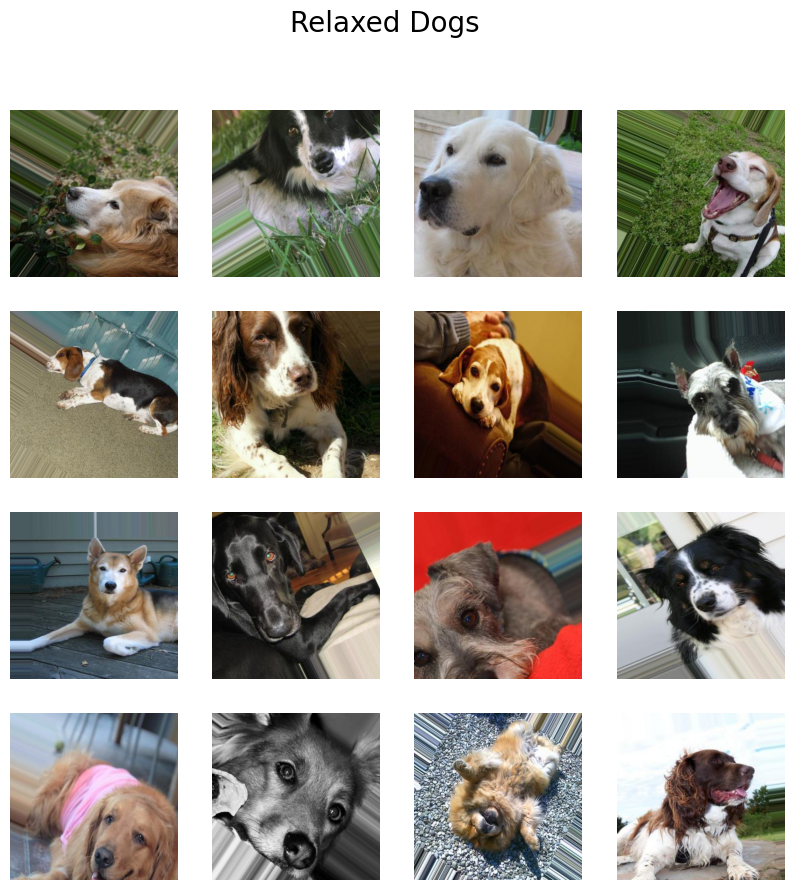

In [37]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_relaxed + train_relaxed_dir[i]), cmap='gray')
    plt.suptitle("Relaxed Dogs",fontsize=20)
    plt.axis('off')

plt.show()

Few characteristics of a Relaxed Dog:  
- You can observe by their posture. Loose shoulders, soft squinty gaze, and body curved in ‘C’ shape are all clues that your dog’s feeling super chill. 
- Dogs crossing their paws are relaxed even though we might not observe from their facial expressions.
- Body is curve shaped and their head is often propped up while lying on their belly.
- Sometimes they may seemed sad from their looks but they are relaxed when body/paws is spread out widely.

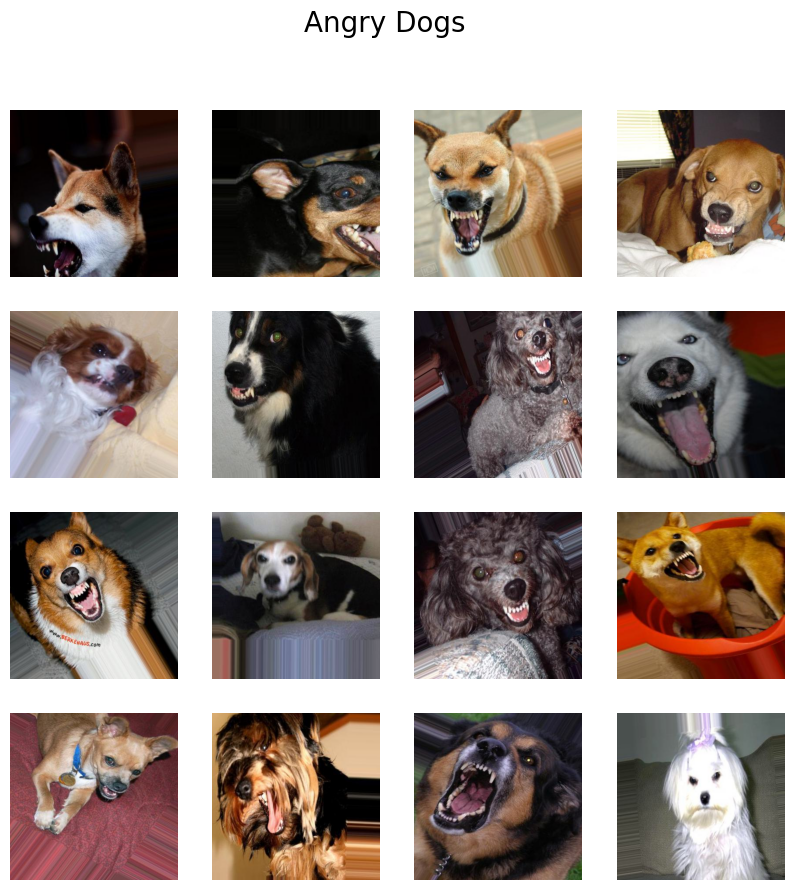

In [47]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_angry + train_angry_dir[i]), cmap='gray')
    plt.suptitle("Angry Dogs",fontsize=20)
    plt.axis('off')

plt.show()

Few characteristics of a Angry Dog:  
- Eyes are usually narrow and appear smaller than normal, almost as if they are squinting
- Lips pulled back and is bearing their teeth. If you notice that their face is in this position and their top and bottom teeth are separated, this is an indication the dog is ready to bite.

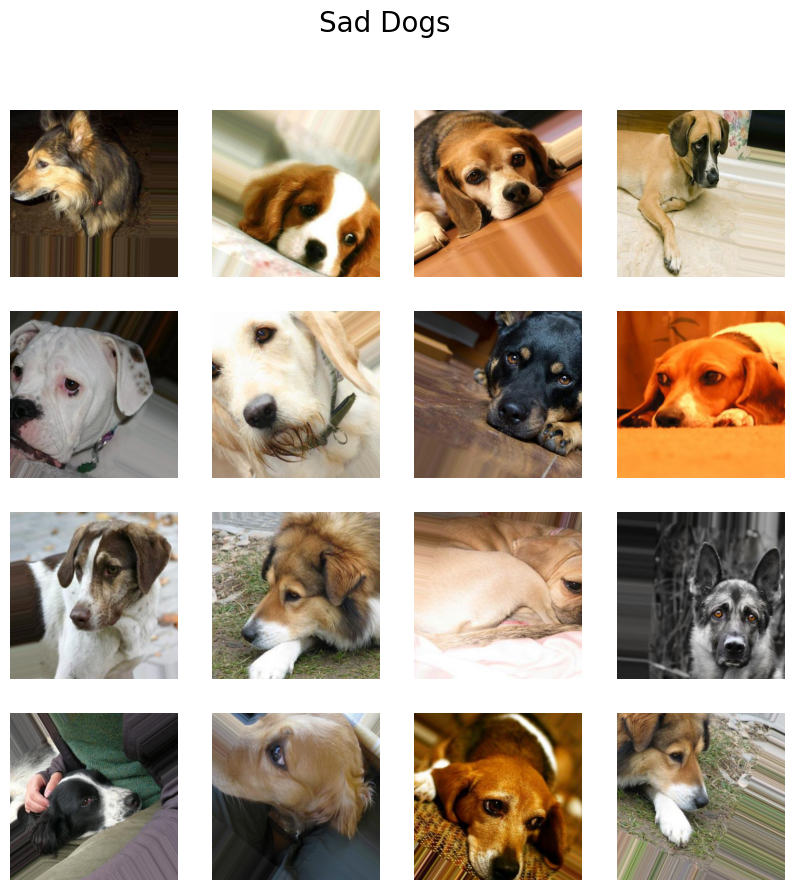

In [48]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_sad + train_sad_dir[i]), cmap='gray')
    plt.suptitle("Sad Dogs",fontsize=20)
    plt.axis('off')

plt.show()

Few characteristics of a Sad Dog:  
- They generally appear smaller where paws are hidden and body is not as wide-spread as compared to relaxed dogs.
- They might look bored but in real fact, when they are bored, they will find things to do instead of lying flat, looking 'sad'.
- Hold their head low and avoid eye contact – this is not guilty face because they don’t have the capacity to feel guilt.

## Modelling

In [11]:
# Define the input and batch size for the images
input_size = (384, 384)
batch_size = 20

# Instantiate an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
)

# Create generators for loading and augmenting images from directories
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8400 images belonging to 4 classes.
Found 1002 images belonging to 4 classes.


### 1. Baseline CNN model

In [50]:
# Instantiate model
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_size + (3,)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')  # Use 'softmax' for multi-class classification
])

optimizer = Adam(lr=0.001)
cnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy', # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])


# Train the model using the generators
history = cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model on the training and validation sets
train_accuracy = cnn.evaluate(train_generator)[1]
test_accuracy = cnn.evaluate(validation_generator)[1]

print("Baseline model Train accuracy:", train_accuracy)
print("Baseline model Validation accuracy:", test_accuracy)


Epoch 1/10
420/420 [==============================] - 660s 2s/step - loss: 1.5626 - accuracy: 0.2992 - val_loss: 1.3974 - val_accuracy: 0.2705
Epoch 2/10
420/420 [==============================] - 643s 2s/step - loss: 1.2526 - accuracy: 0.4036 - val_loss: 1.4403 - val_accuracy: 0.3253
Epoch 3/10
420/420 [==============================] - 631s 2s/step - loss: 0.7843 - accuracy: 0.6752 - val_loss: 2.2976 - val_accuracy: 0.3303
Epoch 4/10
420/420 [==============================] - 633s 2s/step - loss: 0.2118 - accuracy: 0.9280 - val_loss: 4.0746 - val_accuracy: 0.3184
Epoch 5/10
420/420 [==============================] - 639s 2s/step - loss: 0.0567 - accuracy: 0.9877 - val_loss: 5.6923 - val_accuracy: 0.3393
Epoch 6/10
420/420 [==============================] - 633s 2s/step - loss: 0.0402 - accuracy: 0.9930 - val_loss: 5.6674 - val_accuracy: 0.3164
Epoch 7/10
420/420 [==============================] - 637s 2s/step - loss: 0.0128 - accuracy: 0.9976 - val_loss: 6.1588 - val_accuracy: 0.3134

### 2. VGG-16 model

In [51]:
# Instantiate pre-trained VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights="imagenet",
                                                input_shape=input_size + (3,))
# Add Dense Layer to VGG16 model
model = Sequential([vgg16_model,
                    Flatten(),
                    Dense(4, activation = "softmax")]) # Use 'softmax' for multi-class classification

model.layers[0].trainable = False
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Train the model
history =  model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Evaluate the model on the training and validation sets
train_accuracy = model.evaluate(train_generator)[1]
test_accuracy = model.evaluate(validation_generator)[1]

print("VGG16 Train accuracy:", train_accuracy)
print("VGG16 Validation accuracy:", test_accuracy)

Epoch 1/10
420/420 [==============================] - 6304s 15s/step - loss: 1.4390 - accuracy: 0.5721 - val_loss: 1.7603 - val_accuracy: 0.5808
Epoch 2/10
420/420 [==============================] - 5568s 13s/step - loss: 0.3554 - accuracy: 0.8689 - val_loss: 1.7479 - val_accuracy: 0.5399
Epoch 3/10
420/420 [==============================] - 6134s 15s/step - loss: 0.1329 - accuracy: 0.9525 - val_loss: 1.9389 - val_accuracy: 0.5509
Epoch 4/10
420/420 [==============================] - 6128s 15s/step - loss: 0.1218 - accuracy: 0.9561 - val_loss: 2.2037 - val_accuracy: 0.5419
Epoch 5/10
420/420 [==============================] - 5927s 14s/step - loss: 0.1491 - accuracy: 0.9455 - val_loss: 2.6884 - val_accuracy: 0.5329
Epoch 6/10
420/420 [==============================] - 6139s 15s/step - loss: 0.1734 - accuracy: 0.9413 - val_loss: 3.0144 - val_accuracy: 0.5259
Epoch 7/10
420/420 [==============================] - 5575s 13s/step - loss: 0.0931 - accuracy: 0.9661 - val_loss: 3.9322 - val_ac

### 3. MobileNetV2 model

In [60]:
# Instantiate pre-trained MobileNetV2 model
mnet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False,
                                                            weights = "imagenet",
                                                            input_shape=input_size + (3,))

# Clear the Keras session to free up resources
tf.keras.backend.clear_session()

# Add Dense Layer to MobileNetV2 model
model = Sequential([mnet_model,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(4, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
# Train the model
history =  model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Evaluate the model on the training and validation sets
train_accuracy = model.evaluate(train_generator)[1]
test_accuracy = model.evaluate(validation_generator)[1]

print("MobileNetV2 Train accuracy:", train_accuracy)
print("MobileNetV2 Validation accuracy:", test_accuracy)

Epoch 1/10
420/420 [==============================] - 342s 812ms/step - loss: 0.5290 - accuracy: 0.8021 - val_loss: 1.3117 - val_accuracy: 0.5838
Epoch 2/10
420/420 [==============================] - 341s 812ms/step - loss: 0.1780 - accuracy: 0.9385 - val_loss: 1.9132 - val_accuracy: 0.5469
Epoch 3/10
420/420 [==============================] - 342s 814ms/step - loss: 0.1222 - accuracy: 0.9600 - val_loss: 1.7668 - val_accuracy: 0.5539
Epoch 4/10
420/420 [==============================] - 343s 817ms/step - loss: 0.0893 - accuracy: 0.9687 - val_loss: 1.8601 - val_accuracy: 0.5729
Epoch 5/10
420/420 [==============================] - 343s 816ms/step - loss: 0.0703 - accuracy: 0.9777 - val_loss: 2.0484 - val_accuracy: 0.5409
Epoch 6/10
420/420 [==============================] - 341s 813ms/step - loss: 0.0701 - accuracy: 0.9744 - val_loss: 2.0257 - val_accuracy: 0.5888
Epoch 7/10
420/420 [==============================] - 342s 814ms/step - loss: 0.0717 - accuracy: 0.9756 - val_loss: 2.1530 -

### 4. EfficientNet model

In [12]:
# Instantiate pre-trained EfficientNet model
effnet_model = efn.EfficientNetB0(include_top=False,
                                                 weights="imagenet",
                                                 input_shape=input_size + (3,),
                                                 pooling=None,
                                                 classes=4)

# Clear the Keras session to free up resources
tf.keras.backend.clear_session()

# Add Dense Layer to EfficientNet model
effnet = Sequential([effnet_model,
                    Dropout(0.5),
                    Flatten(),
                    BatchNormalization(),
                    Dense(32, kernel_initializer = "he_uniform"),
                    BatchNormalization(),
                    Activation("relu"),
                    Dense(4, activation = "softmax")])

effnet.layers[0].trainable = False

effnet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
# Train the model
history =  effnet.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Evaluate the model on the training and validation sets
train_accuracy = effnet.evaluate(train_generator)[1]
test_accuracy = effnet.evaluate(validation_generator)[1]

print("EfficientNet Train accuracy:", train_accuracy)
print("EfficientNet Validation accuracy:", test_accuracy)

Epoch 1/10
420/420 [==============================] - 673s 2s/step - loss: 0.7989 - accuracy: 0.6832 - val_loss: 0.9488 - val_accuracy: 0.6277
Epoch 2/10
420/420 [==============================] - 683s 2s/step - loss: 0.2812 - accuracy: 0.9179 - val_loss: 1.0940 - val_accuracy: 0.6098
Epoch 3/10
420/420 [==============================] - 695s 2s/step - loss: 0.1579 - accuracy: 0.9556 - val_loss: 1.2509 - val_accuracy: 0.6058
Epoch 4/10
420/420 [==============================] - 709s 2s/step - loss: 0.1174 - accuracy: 0.9674 - val_loss: 1.3700 - val_accuracy: 0.5868
Epoch 5/10
420/420 [==============================] - 683s 2s/step - loss: 0.1023 - accuracy: 0.9681 - val_loss: 1.4940 - val_accuracy: 0.5938
Epoch 6/10
420/420 [==============================] - 677s 2s/step - loss: 0.0987 - accuracy: 0.9679 - val_loss: 1.4388 - val_accuracy: 0.6128
Epoch 7/10
420/420 [==============================] - 676s 2s/step - loss: 0.0855 - accuracy: 0.9723 - val_loss: 1.5096 - val_accuracy: 0.6128

### 5. EfficientNet with 2 classes

As the above CNN models are not yielding good validation score, we will reduce classes from 4 to 2 classes - relaxed and sad, since these two classes are harder to differentiate for new pet owners.

We will use EfficientNet model since it has yield the best accuracy and validation score out of all the CNN models.

In [26]:
# Remove classes 'angry' and 'happy' images from the train and validation directories

train_dir_2 = '../data/train_data_2/'
validation_dir_2 = '../data/validation_data_2/'

In [27]:
# Define the input and batch size for the images
input_size = (384, 384)
batch_size = 20

# Instantiate an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
)

# Create generators for loading and augmenting images from directories
train_generator = datagen.flow_from_directory(
    train_dir_2,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = datagen.flow_from_directory(
    validation_dir_2,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4200 images belonging to 2 classes.
Found 452 images belonging to 2 classes.


In [29]:
# Instantiate pre-trained EfficientNet model
effnet_model2 = efn.EfficientNetB0(include_top=False,
                                                 weights="imagenet",
                                                 input_shape=input_size + (3,),
                                                 pooling=None,
                                                 classes=4)

# Clear the Keras session to free up resources
tf.keras.backend.clear_session()

# Add Dense Layer to EfficientNet model
effnet2 = Sequential([effnet_model2,
                    Dropout(0.5),
                    Flatten(),
                    BatchNormalization(),
                    Dense(32, kernel_initializer = "he_uniform"),
                    BatchNormalization(),
                    Activation("relu"),
                    Dense(2, activation = "softmax")])

effnet2.layers[0].trainable = False

effnet2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
# Train the model
history =  effnet2.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Evaluate the model on the training and validation sets
train_accuracy = effnet2.evaluate(train_generator)[1]
test_accuracy = effnet2.evaluate(validation_generator)[1]

print("EfficientNet_2class Train accuracy:", train_accuracy)
print("EfficientNet_2class Validation accuracy:", test_accuracy)

Epoch 1/10
210/210 [==============================] - 343s 2s/step - loss: 0.3657 - accuracy: 0.8343 - val_loss: 0.3865 - val_accuracy: 0.8717
Epoch 2/10
210/210 [==============================] - 468s 2s/step - loss: 0.1275 - accuracy: 0.9612 - val_loss: 0.4630 - val_accuracy: 0.8252
Epoch 3/10
210/210 [==============================] - 484s 2s/step - loss: 0.0646 - accuracy: 0.9836 - val_loss: 0.4569 - val_accuracy: 0.8385
Epoch 4/10
210/210 [==============================] - 424s 2s/step - loss: 0.0550 - accuracy: 0.9843 - val_loss: 0.5303 - val_accuracy: 0.8274
Epoch 5/10
210/210 [==============================] - 434s 2s/step - loss: 0.0498 - accuracy: 0.9831 - val_loss: 0.5068 - val_accuracy: 0.8451
Epoch 6/10
210/210 [==============================] - 419s 2s/step - loss: 0.0457 - accuracy: 0.9857 - val_loss: 0.5226 - val_accuracy: 0.8518
Epoch 7/10
210/210 [==============================] - 438s 2s/step - loss: 0.0379 - accuracy: 0.9900 - val_loss: 0.5617 - val_accuracy: 0.8385

In [30]:
# Pickle out the EfficientNet_2class model for deployment
effnet2.save("efficientnet2.h5")

## Recommendations

**To foster healthy development of your dogs, there are four major aspects new pet owners could do:**  
**1. Include Social Interactions**  
Set up a doggy playdate with another canine friend  
  
**2. Frequent Play time**  
Exercise & playtime like fetch, brisk walk, toys
Positive reinforcement helps to reinforce good behaviour  
  
**3. Provide a Safe space**  
Provide a comfortable environment, cozy bed and soft toys.  
  
**4. Consider Training**  
If your dog is showing signs of aggression frequently, consult a professional dog trainer

[Click here to Part 1 for details of project](01%20Project%20Details.ipynb)  